<a href="https://colab.research.google.com/github/prikshit-2000/Transformers-NLP/blob/main/Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
# !pip install torch

In [106]:
from torch import Tensor
import torch.nn.functional as f

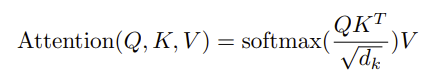

In [107]:
def scaled_dot_product_attention(query : Tensor , key : Tensor, value : Tensor) -> Tensor:
    temp = query.bmm(key.transpose(1,2))
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale , dim = -1)
    return softmax.bmm(value)


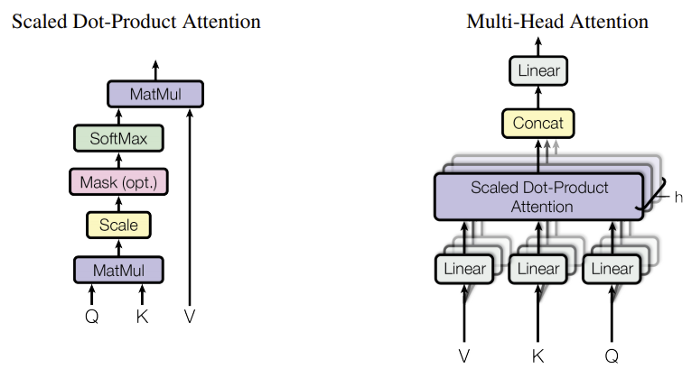

In [108]:
import torch
from torch import nn

class AttentionHead(nn.Module):

    def __init__(self, dim_in : int , dim_k : int ,dim_v: int ):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_k)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_v)
        
    
    def forward(self , query : Tensor , key : Tensor , value : Tensor) -> Tensor:
        return scaled_dot_product_attention(self.q(query) , self.k(key) , self.v(value))


In [109]:
class MultiHeadAttention(nn.Module):

    def __init__(self , num_heads : int ,dim_in : int , dim_k : int ,dim_v: int ):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in,dim_k,dim_v) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_v , dim_in)

    def forward(self , query : Tensor ,key : Tensor ,  value : Tensor) ->Tensor : 
        return self.linear(
            torch.cat([h(query,key,value) for h in self.heads],dim = -1)
        )

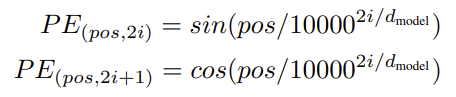

In [110]:

def positional_encoding(
    seq_len: int, dim_model: int, device: torch.device = torch.device("cpu"),
) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / 1e4 ** (dim // dim_model)

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))



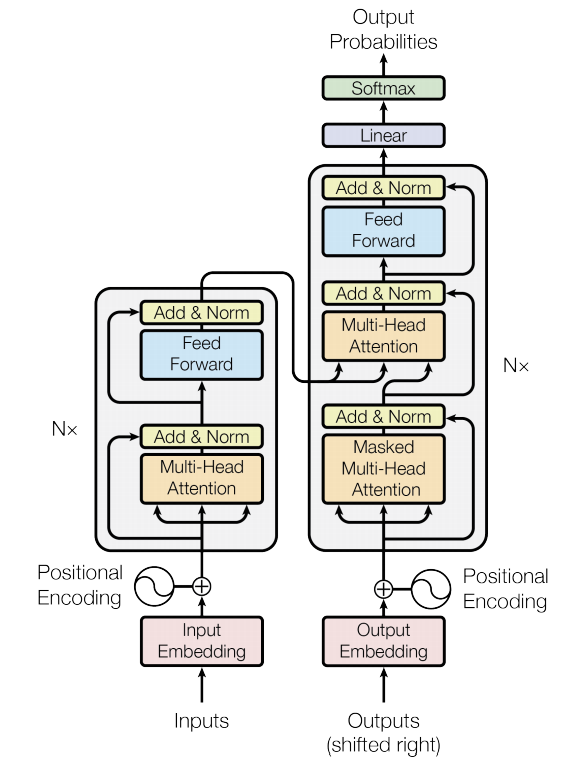

In [111]:
def feed_forward(dim_input : int = 512 , dim_feedforward : int = 2048)-> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input,dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
        
    )

In [112]:
class Residual(nn.Module):

    def __init__(self,sublayer: nn.Module , dimension : int , dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "value" tensor is given last, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[-1] + self.dropout(self.sublayer(*tensors)))

In [113]:
class TransformerEncoderLayer(nn.Module):

    def __init__(
        self,
        dim_model : int = 512,
        num_heads : int = 6,
        dim_feedforward : int = 2048,
        dropout : float = 0.1,
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention = Residual(
            MultiHeadAttention(num_heads , dim_model , dim_k , dim_v),
            dimension = dim_model,
            dropout  = dropout,
        )

        self.feed_forward = Residual(
            feed_forward(dim_model , dim_feedforward),
            dimension = dim_model , 
            dropout = dropout,
        )

    def forward(self , src : Tensor) -> Tensor:
        src = self.attention(src,src,src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):

    def __init__(
        self,
        num_layers : int =6,
        dim_model : int = 512,
        num_heads : int = 8,
        dim_feedforward : int = 2048,
        dropout: float = 0.1,

    ):
        super().__init__()
        self.layers = nn.ModuleList([
        TransformerEncoderLayer(dim_model , num_heads , dim_feedforward , dropout)
        for _ in range(num_layers)
        ])
    def forward(self,src : Tensor) -> Tensor : 
        seq_len , dimension = src.size(1) , src.size(2)

        src+= positional_encoding(seq_len , dimension)
        for layer in self.layers:
            src = layer(src)
        
        return src
    

In [114]:
class TransformerDecoderLayer(nn.Module):

    def __init__(
        self,
        dim_model : int = 512,
        num_heads : int = 6,
        dim_feedforward : int = 2048,
        dropout : float = 0.1,
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention_1= Residual(
            MultiHeadAttention(num_heads , dim_model , dim_k , dim_v),
            dimension = dim_model,
            dropout  = dropout,
        )
        self.attention_2= Residual(
            MultiHeadAttention(num_heads , dim_model , dim_k , dim_v),
            dimension = dim_model,
            dropout  = dropout,
        )

        self.feed_forward = Residual(
            feed_forward(dim_model , dim_feedforward),
            dimension = dim_model , 
            dropout = dropout,
        )

    def forward(self , tgt : Tensor , memory : Tensor) -> Tensor:
        tgt = self.attention_1(tgt,tgt,tgt)
        tgt = self.attention_2(memory,memory,tgt)
        return self.feed_forward(tgt)


class TransformerDecoder(nn.Module):

    def __init__(
        self,
        num_layers: int = 6,
        dim_model : int = 512,
        num_heads : int = 8,
        dim_feedforward : int = 2048,
        dropout: float = 0.1,

    ):
        super().__init__()
        self.layers = nn.ModuleList([
        TransformerDecoderLayer(dim_model , num_heads , dim_feedforward , dropout)
        for _ in range(num_layers)
        ])
        self.linear = nn.Linear(dim_model, dim_model)


    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor : 
        seq_len , dimension = tgt.size(1) , tgt.size(2)

        tgt+= positional_encoding(seq_len , dimension)
        for layer in self.layers:
            tgt = layer(tgt,memory)
        
        return torch.softmax(self.linear(tgt), dim=-1)
    

In [115]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        return self.decoder(tgt, self.encoder(src))

In [116]:
src = torch.rand(64, 16, 512)
tgt = torch.rand(64, 16, 512)
out = Transformer()(src, tgt)
print(out.shape)

torch.Size([64, 16, 512])
